In [1]:
# Standard libraries
import random

# Scientific computing and data handling
import cv2
import numpy as np
import torch

# Image processing
from PIL import Image

# Machine learning utilities and datasets
from sklearn.datasets import fetch_lfw_people
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, roc_curve, auc
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity, euclidean_distances
from sklearn.preprocessing import normalize

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Deep learning models
from facenet_pytorch import MTCNN, InceptionResnetV1

d:\Uni\Year 3\2nd Semester\Biometrics\Project\face-recognition\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading and splitting the dataset

In [2]:
# Load LFW with a minimum number of faces per person, e.g. 30
lfw_people = fetch_lfw_people(min_faces_per_person=30, resize=0.5)  # resize to speed up

# Access images and labels
images = lfw_people.images          # shape: (n_samples, height, width)
labels = lfw_people.target          # integer labels
label_names = lfw_people.target_names  # string names of subjects

print(f"Number of samples: {len(images)}")
print(f"Image shape: {images[0].shape}")
print(f"Number of classes: {len(label_names)}")
print(f"Some classes: {label_names[:5]}")

Number of samples: 2370
Image shape: (62, 47)
Number of classes: 34
Some classes: ['Alejandro Toledo' 'Alvaro Uribe' 'Andre Agassi' 'Ariel Sharon'
 'Arnold Schwarzenegger']


In [3]:
def split_dataset(images, labels, output, train_ratio=0.8):
    X_train, X_test = [], []
    y_train, y_test = [], []
    unique_labels = np.unique(labels)
    
    np.random.seed(42)  # For reproducibility
    
    for label in unique_labels:
        # Indices of images for this subject
        idx = np.where(labels == label)[0]
        
        # Shuffle indices
        shuffled_idx = np.random.permutation(idx)
        
        train_count = int(len(shuffled_idx) * train_ratio)
        
        train_idx = shuffled_idx[:train_count]
        test_idx = shuffled_idx[train_count:]
        
        # Append training samples
        for i in train_idx:
            X_train.append(images[i])
            y_train.append(label)
        
        # Append testing samples
        for i in test_idx:
            X_test.append(images[i])
            y_test.append(label)
    if output == "list":
        return X_train, X_test, y_train, y_test
    elif output == "np":
        return np.array(X_train), np.array(X_test), np.array(y_train), np.array(y_test)

## PCA (Eigenfaces)

### Preprocessing

In [4]:
def preprocess_eigenfaces(images, size=(100, 100)):
    processed_images = []
    for img in images:
        # img is a NumPy array, likely grayscale already if shape is (H, W)
        # Resize image using cv2
        resized_img = cv2.resize(img, size)

        # Normalize to [0, 1]
        normalized_img = resized_img / 255.0

        processed_images.append(normalized_img)

    return np.array(processed_images)

images_preprocessed = preprocess_eigenfaces(images)

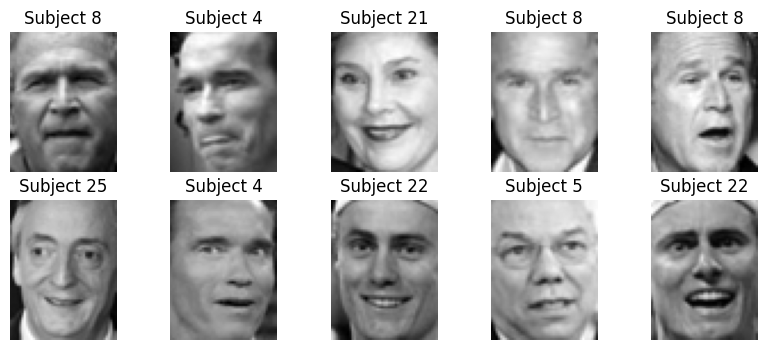

In [5]:
plt.figure(figsize=(10, 4))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Subject {labels[i]}")
    plt.axis("off")

In [6]:
X_train, X_test, y_train, y_test = split_dataset(images_preprocessed, labels, 'np')

In [7]:
# Flatten 2D images (height x width) into 1D vectors for PCA
num_train = X_train.shape[0]
height, width = X_train.shape[1], X_train.shape[2]

X_train_flat = X_train.reshape(num_train, height * width).astype(np.float64)
X_test_flat = X_test.reshape(X_test.shape[0], height * width).astype(np.float64)

print(f"Each image is now a vector of length {X_train_flat.shape[1]}")

Each image is now a vector of length 10000


### Feature Extraction

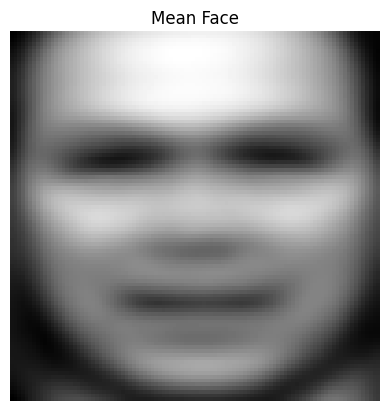

In [8]:
# Calculate the mean face
mean_face = np.mean(X_train_flat, axis=0)

# Visualize the mean face
plt.imshow(mean_face.reshape(height, width), cmap='gray')
plt.title("Mean Face")
plt.axis('off')
plt.show()


In [9]:
# Center the training data by subtracting the mean face
X_train_centered = X_train_flat - mean_face

In [10]:
# Compute smaller covariance matrix L = X_train_centered * X_train_centered.T
L = np.dot(X_train_centered, X_train_centered.T)

print(f"Shape of L (small covariance matrix): {L.shape}")

Shape of L (small covariance matrix): (1881, 1881)


In [11]:
eigenvalues, eigenvectors_small = np.linalg.eigh(L)  # eigh for symmetric matrix

# Sort eigenvalues and eigenvectors descending
idx = np.argsort(eigenvalues)[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors_small = eigenvectors_small[:, idx]

In [12]:
eigenfaces = np.dot(X_train_centered.T, eigenvectors_small)  # shape (N, M)

# Normalize eigenfaces to unit length
eigenfaces = eigenfaces / np.linalg.norm(eigenfaces, axis=0)

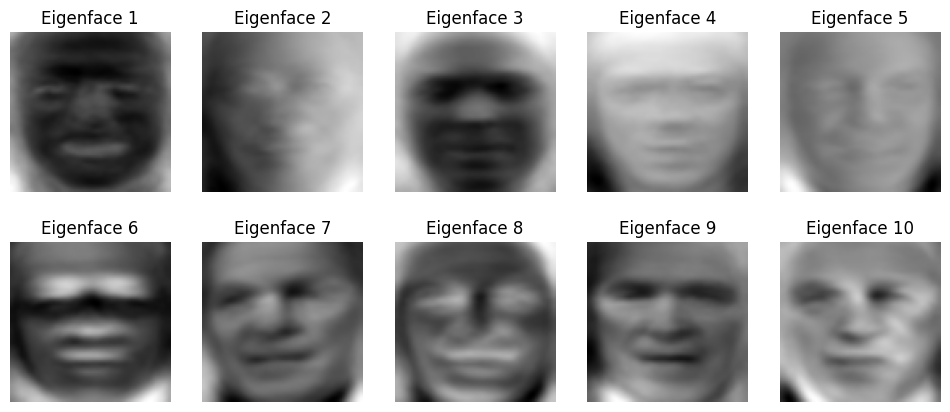

In [13]:
plt.figure(figsize=(12, 5))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(eigenfaces[:, i].reshape(height, width), cmap='gray')
    plt.title(f"Eigenface {i+1}")
    plt.axis('off')
plt.show()

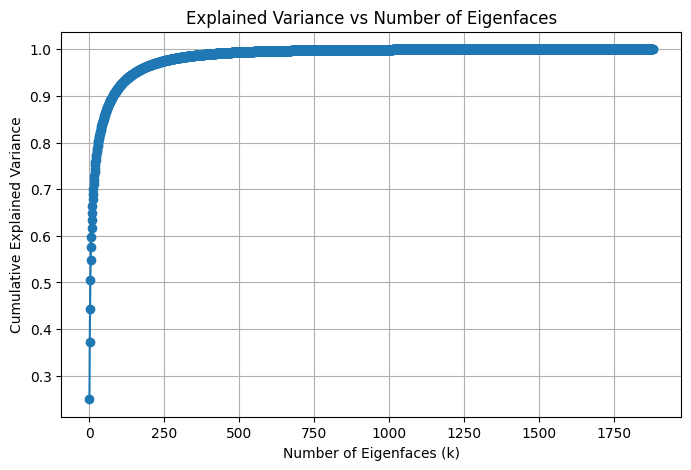

In [14]:
# Calculate explained variance ratio and cumulative variance
explained_variance_ratio = eigenvalues / np.sum(eigenvalues)
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs Number of Eigenfaces')
plt.grid(True)
plt.show()

In [15]:
# Center test faces
X_test_centered = X_test_flat - mean_face

In [16]:
def recognize_faces(weights_train, y_train, weights_test):
    y_pred = []
    for w in weights_test:
        distances = np.linalg.norm(weights_train - w, axis=1)
        idx_min = np.argmin(distances)
        y_pred.append(y_train[idx_min])
    return np.array(y_pred)

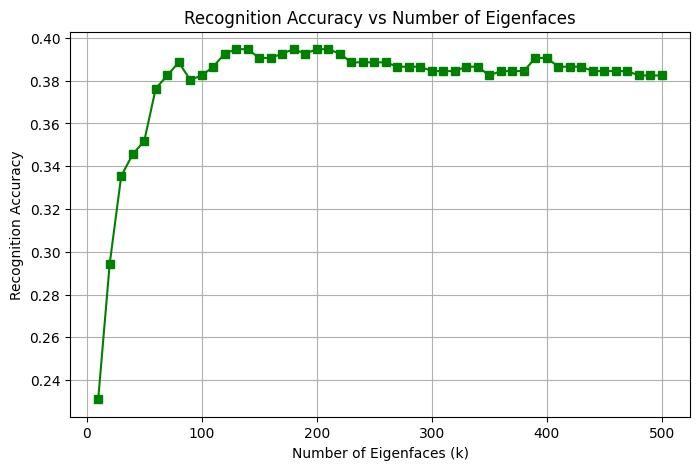

In [17]:
# Evaluate accuracy over different k values
k_values = range(10, min(len(eigenvalues), 501), 10)
accuracies = []

for k in k_values:
    eigenfaces_k = eigenfaces[:, :k]
    weights_train = np.dot(X_train_centered, eigenfaces_k)
    weights_test = np.dot(X_test_centered, eigenfaces_k)
    y_pred = recognize_faces(weights_train, y_train, weights_test)
    acc = np.mean(y_pred == y_test)
    accuracies.append(acc)

# Plot accuracy vs number of eigenfaces
plt.figure(figsize=(8, 5))
plt.plot(k_values, accuracies, marker='s', color='green')
plt.xlabel('Number of Eigenfaces (k)')
plt.ylabel('Recognition Accuracy')
plt.title('Recognition Accuracy vs Number of Eigenfaces')
plt.grid(True)
plt.show()

In [18]:
# Pick your chosen k
k = 200

# Select top k eigenfaces
eigenfaces_k = eigenfaces[:, :k]

# Project training and test data into eigenface space
weights_train = np.dot(X_train_centered, eigenfaces_k)
weights_test = np.dot(X_test_centered, eigenfaces_k)


### Matching

In [19]:
# Predict on test set
y_pred = recognize_faces(weights_train, y_train, weights_test)

# Compute accuracy
accuracy = np.mean(y_pred == y_test)
print(f"Recognition accuracy with k={k} eigenfaces: {accuracy * 100:.2f}%")

Recognition accuracy with k=200 eigenfaces: 39.47%


In [20]:
def generate_genuine_impostor_scores(embeddings, labels, impostor_sample_size=10000):
    genuine_scores = []
    impostor_scores = []

    label_to_indices = {}
    for idx, label in enumerate(labels):
        label_to_indices.setdefault(label, []).append(idx)
    label_list = list(label_to_indices.keys())

    # All genuine pairs
    for indices in label_to_indices.values():
        for i in range(len(indices)):
            for j in range(i + 1, len(indices)):
                a, b = embeddings[indices[i]], embeddings[indices[j]]
                score = cosine_similarity([a], [b])[0][0]
                genuine_scores.append(score)

    # Random impostor pairs (limit to impostor_sample_size)
    while len(impostor_scores) < impostor_sample_size:
        label1, label2 = random.sample(label_list, 2)
        i = random.choice(label_to_indices[label1])
        j = random.choice(label_to_indices[label2])
        a, b = embeddings[i], embeddings[j]
        score = cosine_similarity([a], [b])[0][0]
        impostor_scores.append(score)

    return np.array(genuine_scores), np.array(impostor_scores)

genuine_scores, impostor_scores = generate_genuine_impostor_scores(normalize(weights_train), y_train)

### Curves

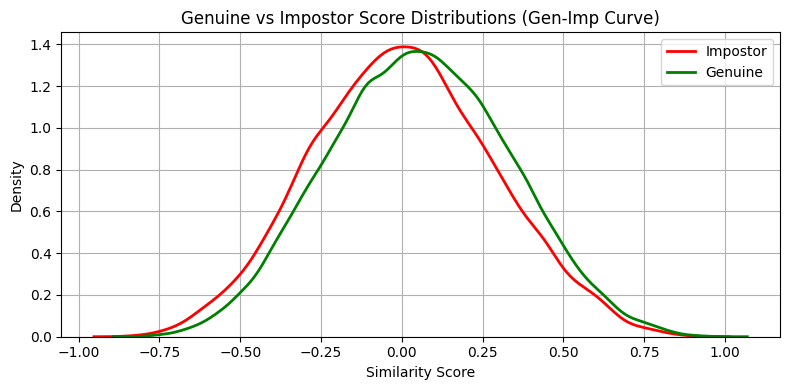

In [21]:
# Gen-Imp Curve
plt.figure(figsize=(8, 4))
    
sns.kdeplot(impostor_scores, label="Impostor", color='red', linewidth=2)
sns.kdeplot(genuine_scores, label="Genuine", color='green', linewidth=2)

plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.title("Genuine vs Impostor Score Distributions (Gen-Imp Curve)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

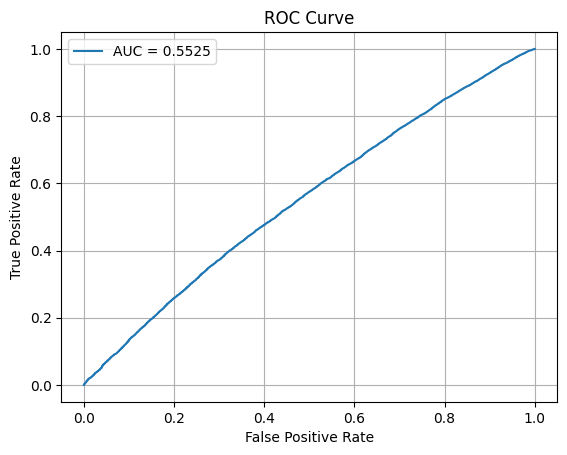

In [22]:
# ROC Curve
y_true = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])
y_scores = np.concatenate([genuine_scores, impostor_scores])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

### Metrics

In [23]:
def compute_eer(fpr, tpr, thresholds):
    fnr = 1 - tpr
    eer_idx = np.nanargmin(np.absolute((fnr - fpr)))
    eer = (fpr[eer_idx] + fnr[eer_idx]) / 2
    threshold = thresholds[eer_idx]
    return eer, threshold

eer, eer_thresh = compute_eer(fpr, tpr, thresholds)
print(f"EER: {eer:.4f} at threshold {eer_thresh:.4f}")

EER: 0.4632 at threshold 0.0270


In [24]:
def compute_dprime(genuine, impostor):
    mu_g, mu_i = np.mean(genuine), np.mean(impostor)
    std_g, std_i = np.std(genuine), np.std(impostor)
    return (mu_g - mu_i) / np.sqrt(0.5 * (std_g**2 + std_i**2))

dprime = compute_dprime(genuine_scores, impostor_scores)
print(f"d-prime: {dprime:.4f}")

d-prime: 0.1859


In [25]:
def compute_tmr_at_fmr(fpr, tpr, fmr_target=0.01):
    idx = np.argmin(np.abs(fpr - fmr_target))
    return tpr[idx], fpr[idx]

tmr, fmr = compute_tmr_at_fmr(fpr, tpr, fmr_target=0.01)
print(f"TMR at FMR=1%: {tmr:.4f} (actual FMR={fmr:.4f})")
tmr, fmr = compute_tmr_at_fmr(fpr, tpr, fmr_target=0.0001)
print(f"TMR at FMR=0.01%: {tmr:.4f} (actual FMR={fmr:.4f})")

TMR at FMR=1%: 0.0173 (actual FMR=0.0100)
TMR at FMR=0.01%: 0.0004 (actual FMR=0.0001)


In [26]:
def compute_rank1_accuracy(X_train, y_train, X_test, y_test):
    dists = euclidean_distances(X_test, X_train)
    nn_indices = np.argmin(dists, axis=1)
    y_pred = y_train[nn_indices]
    return accuracy_score(y_test, y_pred)

rank1_acc = compute_rank1_accuracy(weights_train, y_train, weights_test, y_test)
print(f"Rank-1 Accuracy (TPIR): {rank1_acc:.4f}")

Rank-1 Accuracy (TPIR): 0.3947


In [27]:
def compute_fpir_fnir(genuine, impostor, threshold):
    false_non_matches = np.sum(genuine < threshold)
    false_positive_matches = np.sum(impostor >= threshold)

    fpir = false_positive_matches / len(impostor)
    fnir = false_non_matches / len(genuine)
    return fpir, fnir

fpir, fnir = compute_fpir_fnir(genuine_scores, impostor_scores, eer_thresh)
print(f"FPIR: {fpir:.4f}, FNIR: {fnir:.4f}")

FPIR: 0.4632, FNIR: 0.4632


## FaceNet-based

In [28]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Initialize MTCNN (face detection + alignment)
mtcnn = MTCNN(image_size=160, margin=20, device=device)

### Preprocessing

In [29]:
def preprocess_facenet(images):
    aligned_faces = []
    for img_np in images:
        if img_np.dtype != 'uint8':
            img_np = (img_np * 255).astype('uint8')
        # Resize to at least 160x160 for MTCNN input
        img_np_resized = cv2.resize(img_np, (160, 160))
        img_pil = Image.fromarray(img_np_resized).convert("RGB")
        face = mtcnn(img_pil)
        aligned_faces.append(face)
    return np.array(aligned_faces, dtype=object)


images_preprocessed = preprocess_facenet(images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.94140625..0.58984375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.97265625..0.44921875].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92578125..0.43359375].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.85546875..0.62890625].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.97265625..0.41796875].


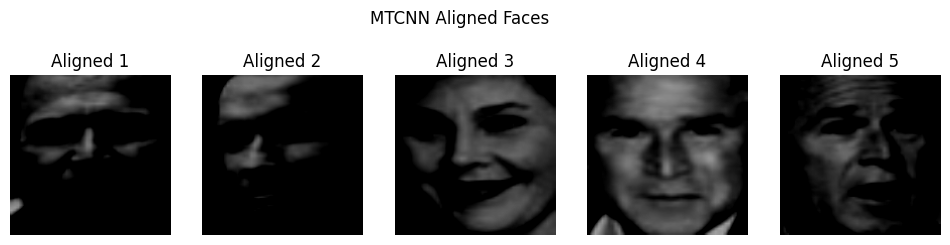

In [30]:
plt.figure(figsize=(12, 3))
count = 0
for image in images_preprocessed:
    if image is not None:
        plt.subplot(1, 5, count + 1)
        plt.imshow(image.permute(1, 2, 0).cpu().numpy())
        plt.title(f"Aligned {count+1}")
        plt.axis('off')
        count += 1
    if count == 5:
        break
plt.suptitle("MTCNN Aligned Faces")
plt.show()

In [31]:
X_train, X_test, y_train, y_test = split_dataset(images_preprocessed, labels, 'list')

### Feature Extraction

In [32]:
# Load pre-trained FaceNet model
facenet = InceptionResnetV1(pretrained='vggface2').eval().to(device)

# Get 128D embeddings
def extract_embeddings(aligned_faces):
    embeddings = []
    for face in aligned_faces:
        if face is None:
            embeddings.append(None)
            continue

        # If input is a NumPy array (rare at this stage), convert
        if isinstance(face, np.ndarray):
            face = torch.tensor(face).permute(2, 0, 1).float() / 255.0

        # Ensure shape (3, 160, 160)
        if isinstance(face, torch.Tensor) and face.shape[0] != 3:
            face = face.permute(2, 0, 1)

        face = face.unsqueeze(0).to(device)  # (1, 3, 160, 160)
        with torch.no_grad():
            emb = facenet(face).cpu().numpy()[0]
        embeddings.append(emb)
    return np.array(embeddings, dtype=object)

train_embs = extract_embeddings(X_train)
test_embs = extract_embeddings(X_test)

In [33]:
def filter_valid_embeddings(embeddings, labels):
    valid_embs = []
    valid_labels = []
    for emb, label in zip(embeddings, labels):
        if emb is not None:
            valid_embs.append(emb)
            valid_labels.append(label)
    return np.array(valid_embs), np.array(valid_labels)

train_embs, y_train = filter_valid_embeddings(train_embs, y_train)
test_embs, y_test = filter_valid_embeddings(test_embs, y_test)

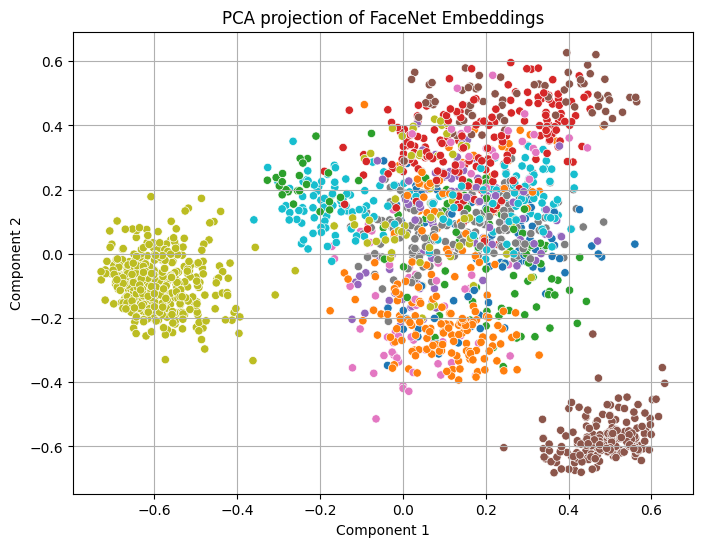

In [34]:
reducer = PCA(n_components=2)

emb_2d = reducer.fit_transform(np.vstack(train_embs))
plt.figure(figsize=(8, 6))
sns.scatterplot(x=emb_2d[:, 0], y=emb_2d[:, 1], hue=y_train, palette='tab10', legend=False)
plt.title("PCA projection of FaceNet Embeddings")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.grid(True)
plt.show()

### Matching

In [35]:
def predict_label(test_emb, train_embs, train_labels):
    distances = cosine_distances([test_emb], train_embs)[0]
    return train_labels[np.argmin(distances)]


def predict_all(test_embs, train_embs, train_labels):
    return np.array([predict_label(e, train_embs, train_labels) for e in test_embs])

# Predict
y_pred = predict_all(test_embs, train_embs, y_train)

# Evaluate
acc = accuracy_score(y_test, y_pred)
print(f"Face Recognition Accuracy: {acc * 100:.2f}%")


Face Recognition Accuracy: 99.79%


In [36]:
genuine_scores, impostor_scores = generate_genuine_impostor_scores(train_embs, y_train)

### Curves

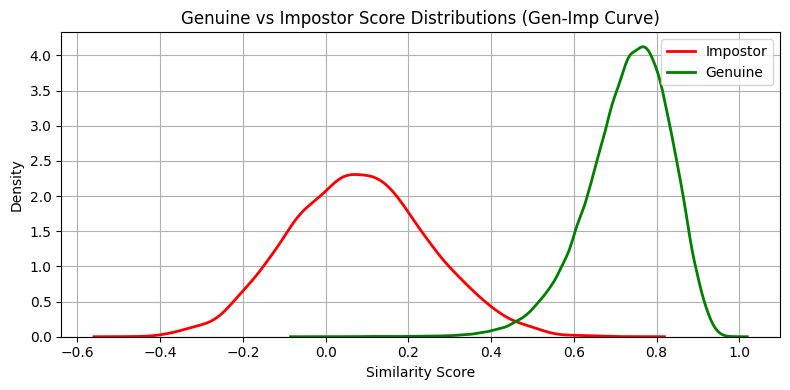

In [37]:
# Gen-Imp Curve
plt.figure(figsize=(8, 4))
    
sns.kdeplot(impostor_scores, label="Impostor", color='red', linewidth=2)
sns.kdeplot(genuine_scores, label="Genuine", color='green', linewidth=2)

plt.xlabel("Similarity Score")
plt.ylabel("Density")
plt.title("Genuine vs Impostor Score Distributions (Gen-Imp Curve)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

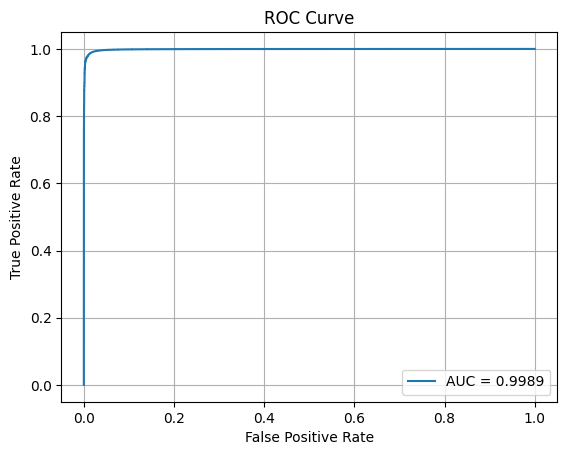

In [38]:
# ROC Curve
y_true = np.concatenate([np.ones_like(genuine_scores), np.zeros_like(impostor_scores)])
y_scores = np.concatenate([genuine_scores, impostor_scores])

fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.grid(True)
plt.legend()
plt.show()

### Metrics

In [39]:
eer, eer_thresh = compute_eer(fpr, tpr, thresholds)
print(f"EER: {eer:.4f} at threshold {eer_thresh:.4f}")

EER: 0.0136 at threshold 0.4602


In [40]:
dprime = compute_dprime(genuine_scores, impostor_scores)
print(f"d-prime: {dprime:.4f}")

d-prime: 4.6747


In [41]:
tmr, fmr = compute_tmr_at_fmr(fpr, tpr, fmr_target=0.01)
print(f"TMR at FMR=1%: {tmr:.4f} (actual FMR={fmr:.4f})")
tmr, fmr = compute_tmr_at_fmr(fpr, tpr, fmr_target=0.0001)
print(f"TMR at FMR=0.01%: {tmr:.4f} (actual FMR={fmr:.4f})")

TMR at FMR=1%: 0.9815 (actual FMR=0.0100)
TMR at FMR=0.01%: 0.5062 (actual FMR=0.0001)


In [42]:
rank1_acc = compute_rank1_accuracy(train_embs, y_train, test_embs, y_test)
print(f"Rank-1 Accuracy (TPIR): {rank1_acc:.4f}")

Rank-1 Accuracy (TPIR): 0.9979


In [43]:
fpir, fnir = compute_fpir_fnir(genuine_scores, impostor_scores, eer_thresh)
print(f"FPIR: {fpir:.4f}, FNIR: {fnir:.4f}")

FPIR: 0.0136, FNIR: 0.0136
